In [ ]:
# This jupyter notebook demonstrates how to predict stock with LSTM(long-short term memory) to 
# predict stock price of the next day

# In this tutorial, we are going to use yahoo finance (called yfinance https://github.com/ranaroussi/yfinance) 
# packages to download market data in daily basis.

# For model training and prediction, we partition the whole stock price series into several time-windowed (defined by n)
# sequence for input and use tensorflow to build the model.

# reference:
# [1] https://colab.research.google.com/drive/1Bk4zPQwAfzoSHZokKUefKL1s6lqmam6S?usp=sharing#scrollTo=8b-JsTvEWfAm
# [2] https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

In [1]:
# Install the required package with script mode
!pip install pandas_datareader yfinance

In [2]:
import pandas as pd
import numpy as np

# For plot
import matplotlib.pyplot as plt

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

In [3]:
# First step, let's download the target symbol with a preferred duration
# In the example below, we are downloading the market data of the last year from 
# $MSFT (https://finance.yahoo.com/quote/MSFT/)
# then we use globals() to converts the stock symbol into python varialbe

# You could download as many as symbol together as you can.

tech_list = ['MSFT', 'AAPL', 'TSLA', 'VOO']


end = datetime.now() 
start = datetime(end.year - 1, end.month, end.day) # get the whole year stock price history

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Summary Stats
# columns including 
#  Open (Opening stock price)
#  High (the highest price during the day)
#  Low (the lowest price during the day)
#  Close (the stock price) 
#  Adj Close (Adjusted closed price)
#  Volume (the transaction volume)

MSFT.describe()

,Open,High,Low,Close,Adj Close,Volume
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02
mean,295.981653,298.790394,292.742913,295.878661,294.981306,2.865750e+07
std,25.165342,25.269744,24.798586,25.100770,25.273783,1.102301e+07
min,239.309998,243.229996,238.070007,239.000000,237.068985,1.390020e+07
25%,282.105003,286.367508,278.440002,280.992508,280.569992,2.142035e+07
50%,296.180008,298.630005,293.259995,295.975006,295.319580,2.627250e+07
75%,309.595001,312.267502,306.437492,310.177505,309.519325,3.360290e+07
max,344.619995,349.670013,342.200012,343.109985,342.402008,9.042890e+07


In [5]:
# General info
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2021-05-11 to 2022-05-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       254 non-null    float64
 1   High       254 non-null    float64
 2   Low        254 non-null    float64
 3   Close      254 non-null    float64
 4   Adj Close  254 non-null    float64
 5   Volume     254 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.9 KB


In [6]:
# On each row presents several columns including 
#  Open (Opening stock price)
#  High (the highest price during the day)
#  Low (the lowest price during the day)
#  Close (the stock price) 
#  Adj Close (Adjusted closed price)
#  Volume (the transaction volume)

# and each row is indexed by Date (e.g. 2021-05-10)
print(MSFT)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-05-11  244.550003  246.600006  242.570007  246.229996  244.240540   
2021-05-12  242.169998  244.380005  238.070007  239.000000  237.068985   
2021-05-13  241.800003  245.600006  241.419998  243.029999  241.066406   
2021-05-14  245.580002  249.179993  245.490005  248.149994  246.145050   
2021-05-17  246.550003  246.589996  243.520004  245.179993  243.199036   
...                ...         ...         ...         ...         ...   
2022-05-05  285.540009  286.350006  274.339996  277.350006  277.350006   
2022-05-06  274.809998  279.250000  271.269989  274.730011  274.730011   
2022-05-09  270.059998  272.359985  263.320007  264.579987  264.579987   
2022-05-10  271.690002  273.750000  265.070007  269.500000  269.500000   
2022-05-11  265.679993  271.359985  259.299988  260.549988  260.549988   

              Volume  
Date          

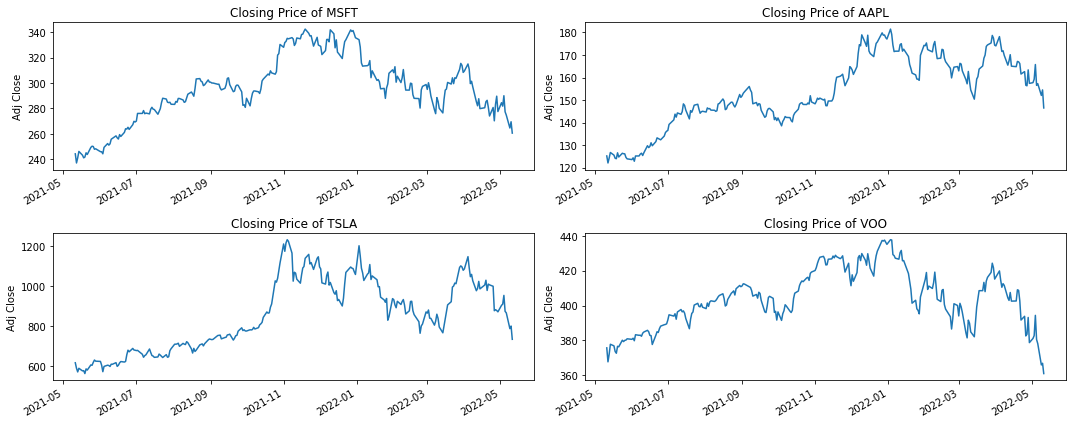

In [7]:
# Let's do some data visualization to dig the stock price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

company_list = [MSFT, AAPL, TSLA, VOO]

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

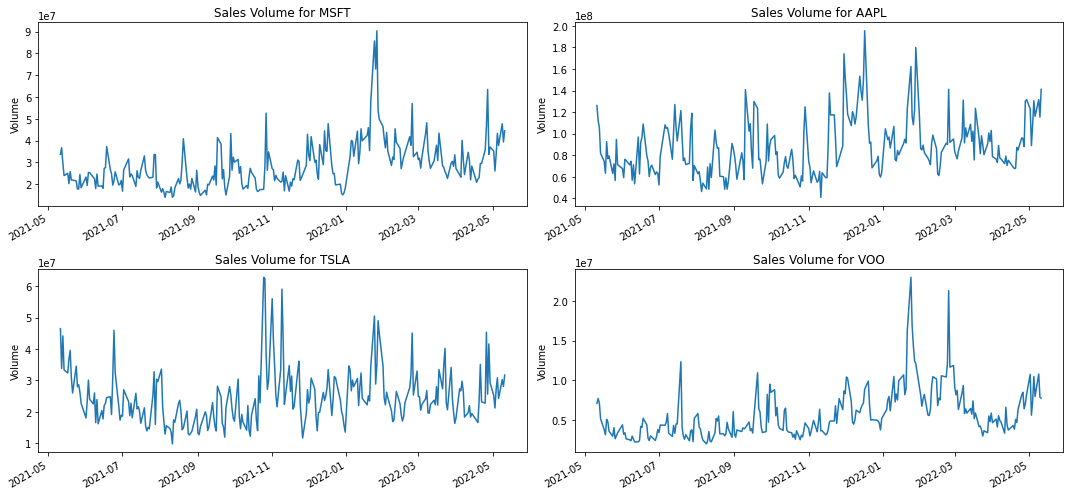

In [8]:
# Now let's plot the total volume of stock being traded each day

plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

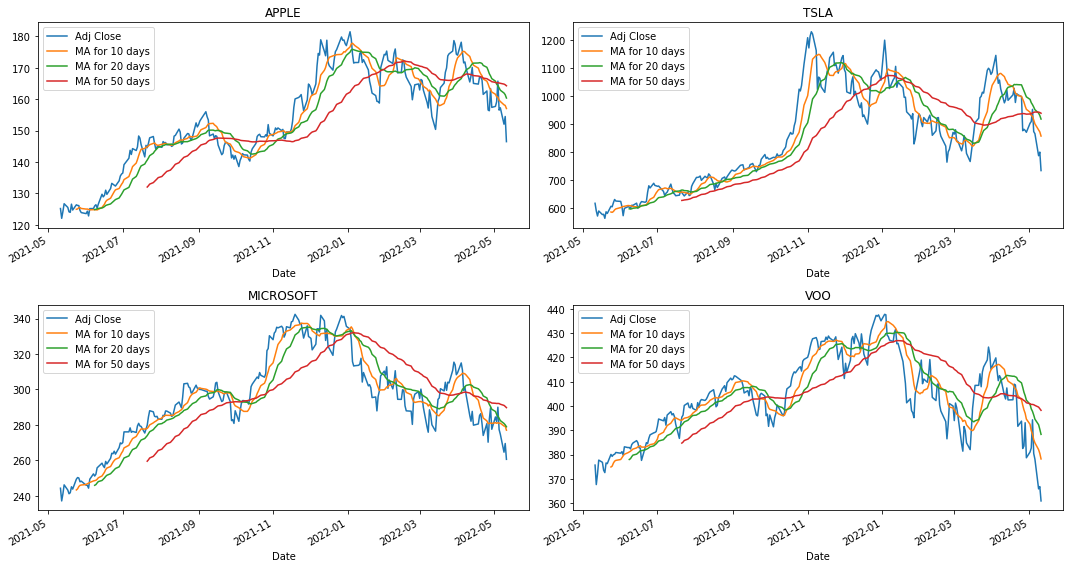

In [9]:
# Let's do a moving average on the each ticket

ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

TSLA[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('TSLA')

VOO[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('VOO')

fig.tight_layout()

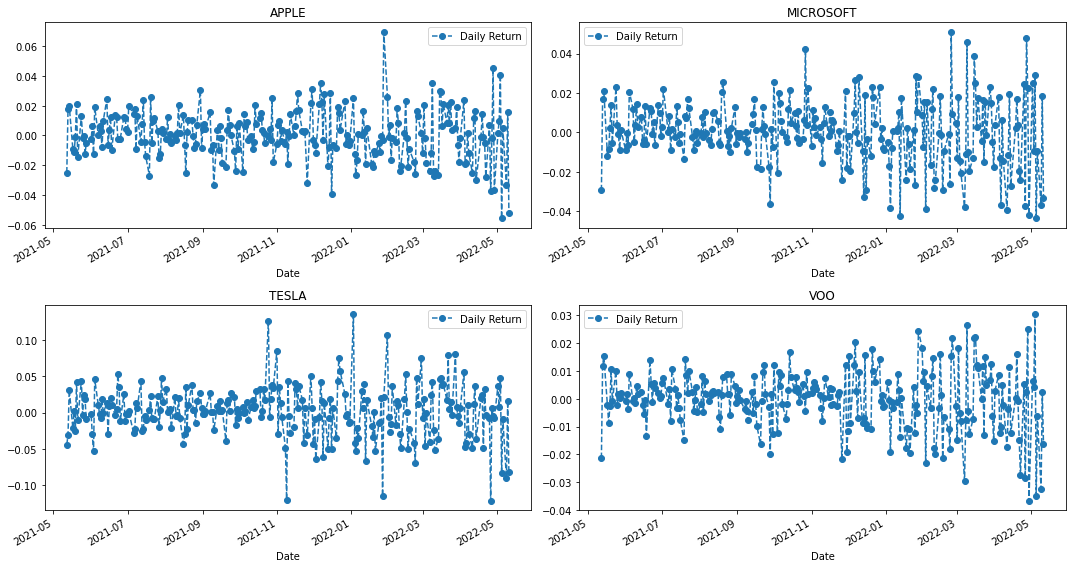

In [10]:
# pct_change means the percent change for each day
# If the number is higher, usually means that the symbol has higher rick (or higher rewards)

for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

MSFT['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('MICROSOFT')

TSLA['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('TESLA')

VOO['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('VOO')

fig.tight_layout()

In [11]:
# As we are focusing on predicting the stock price,
# we projected fields 'Date' and 'Close' for the further usage.

# add index to column
MSFT['Date'] = MSFT.index

MSFT_df = MSFT[['Date', 'Close']]

In [12]:
print(MSFT_df)

                 Date       Close
Date                             
2021-05-11 2021-05-11  246.229996
2021-05-12 2021-05-12  239.000000
2021-05-13 2021-05-13  243.029999
2021-05-14 2021-05-14  248.149994
2021-05-17 2021-05-17  245.179993
...               ...         ...
2022-05-05 2022-05-05  277.350006
2022-05-06 2022-05-06  274.730011
2022-05-09 2022-05-09  264.579987
2022-05-10 2022-05-10  269.500000
2022-05-11 2022-05-11  260.549988

[254 rows x 2 columns]


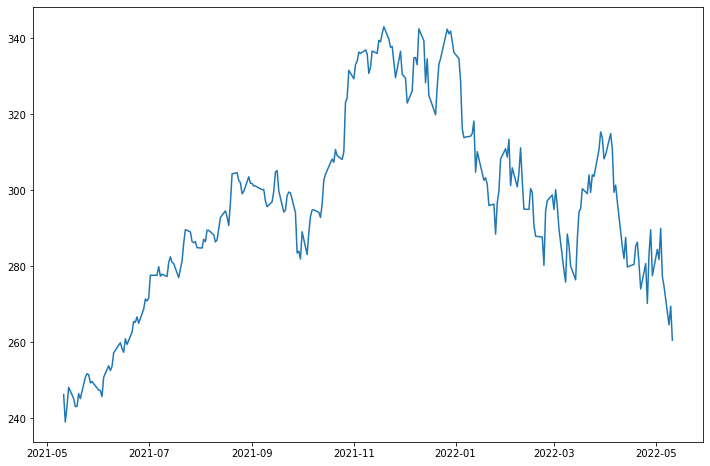

In [13]:
plt.figure(figsize=(12,8))
plt.plot(MSFT_df['Date'], MSFT_df['Close'])

In [14]:
# As we mentioned earier, for LSTM we use a sequence of events (or data) to predict what is the 
# stock price next, so we need to segment a whole year data into multiple sequences with a predefined
# time-window.
# It means we are grouping stock prices of three consecutive day into one sequence if n is 3.

# convert dateframe into multiple sequences of array, each sequence is with size $n
def df_to_windowed_df(dataframe, n=3):

  (num_columns, num_rows) = dataframe.shape  

  dates = []
  X, Y = [], []
  
  for index in range(n, num_columns):
    # for example, we are grouping each the role illustrated below
    # df_end_date = 2021-05-13
    # df_end_value = sp(2021-05-13)
    # df_seuqnece = [sp(2021-05-10), sp(2021-05-11), sp(2021-05-12)]
    
    df_end_date = dataframe.iloc[index]['Date']
    df_end_value = dataframe.iloc[index]['Close']
    df_seuqnece = dataframe.iloc[index-n:index]
    df_values = df_seuqnece['Close'].to_numpy()
    x, y = df_values, df_end_value
    
    dates.append(df_end_date)
    X.append(x)
    Y.append(y)
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(MSFT_df,n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-05-14,246.229996,239.000000,243.029999,248.149994
1,2021-05-17,239.000000,243.029999,248.149994,245.179993
2,2021-05-18,243.029999,248.149994,245.179993,243.080002
3,2021-05-19,248.149994,245.179993,243.080002,243.119995
4,2021-05-20,245.179993,243.080002,243.119995,246.479996
...,...,...,...,...,...
246,2022-05-05,284.470001,281.779999,289.980011,277.350006
247,2022-05-06,281.779999,289.980011,277.350006,274.730011
248,2022-05-09,289.980011,277.350006,274.730011,264.579987
249,2022-05-10,277.350006,274.730011,264.579987,269.500000


In [15]:
# now, we convert the dataframe into numby vector for further processing

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((251,), (251, 3, 1), (251,))

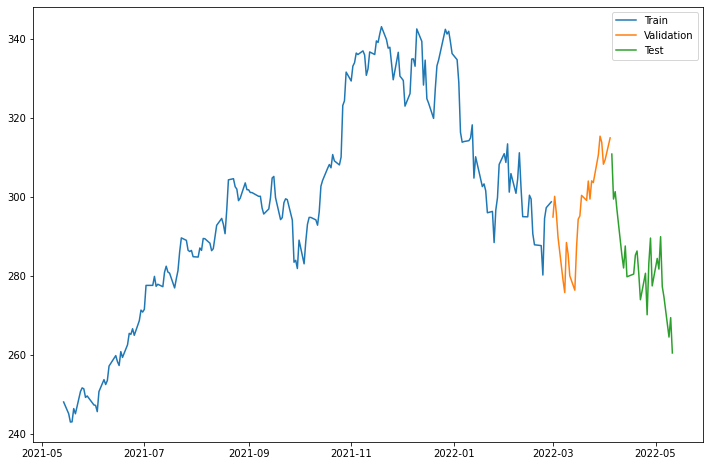

In [16]:
# In the following setup, we use the first 80th data samples as a training
# and use 80th to 90th as validation
# and the rest is for testing.
# You can see each numbers plotted below.

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(12,8))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [17]:
# Now we build a tensorflow model with LSTM
# the network is not something fancy, it is just a common way to build the model
# And you can also find a better model online.

# Note the input tensor size should have equal length with the windows size.
# In this example, we use windows size (n=3), so the input tensor is layers.Input((3, 1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 102ms/step - loss: 89502.5000 - mean_absolute_error: 298.0081 - val_loss: 88014.0781 - val_mean_absolute_error: 296.4394
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 89106.2812 - mean_absolute_error: 297.3414 - val_loss: 87614.5938 - val_mean_absolute_error: 295.7648
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 88698.9219 - mean_absolute_error: 296.6534 - val_loss: 87156.7578 - val_mean_absolute_error: 294.9897
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 88169.0000 - mean_absolute_error: 295.7610 - val_loss: 86562.6328 - val_mean_absolute_error: 293.9811
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 87569.5312 - mean_absolute_error: 294.7452 - val_loss: 85950.8828 - val_mean_absolute_error: 292.9388
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 86926.6094 - mean_absolute_error: 293.6571 - val_loss: 852

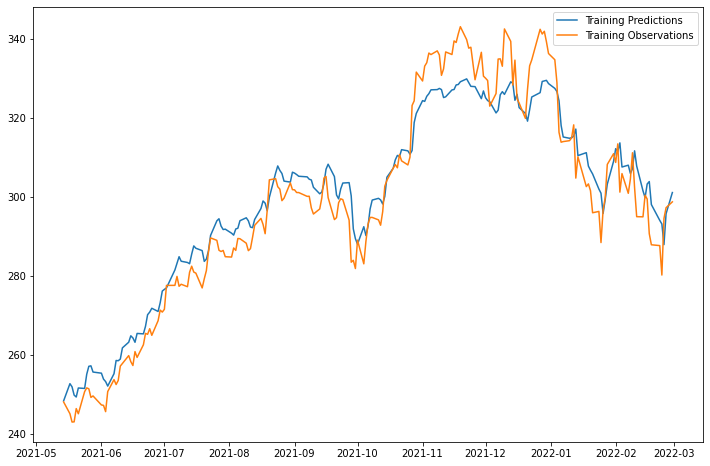

In [18]:
# We plotted the training prediction vs training observation (i.e. the target value in the traingin data)
# The differences of each time series of a given time point stands for the error from the ground truth
# and the expectation.

train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12,8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

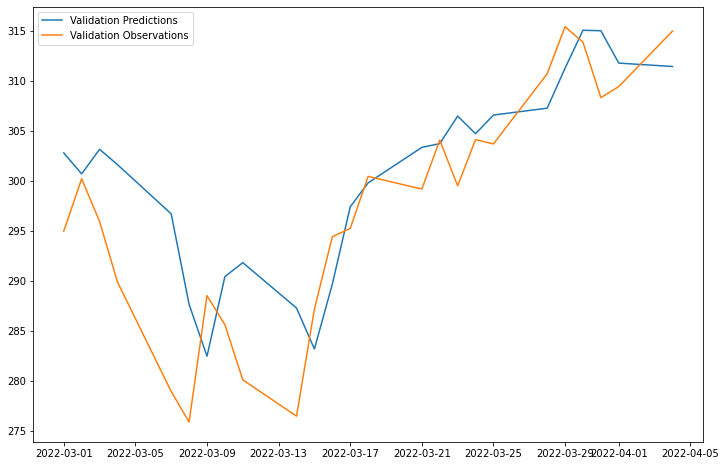

In [19]:
# We plotted the validation results below.

val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12,8))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [ ]:
# And the final the results from test dataset

test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12,8))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
# Now we combining them together to see differences.

plt.figure(figsize=(12,8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
# Open questions

# 
# 1. LSTM or not: does it make any sense that the stock price of the next day will be determined 
# by the previous n days? As the stock price is more like a random-walk model and be affected by
# the global/local economic and events.

# 2. Normalization (min,max normalization) or standardalization (v - mean/std) are common approach 
# to fit the feature vectors into a fesible value range, but is it useful on predicting stock price?
